# Assignment 2

This assignment serves as a comprehensive evaluation of your machine learning skills, encompassing not only the technical aspects of model development but also your ability to analyze, interpret, and present data insights effectively. As such, it's essential to ensure that your submission is complete, functional, and devoid of any obvious gaps, as if you were delivering this project to a client.

To achieve this, leverage the full capabilities of Markdown and the interactive visualization tools available in Jupyter notebooks to craft a well-structured and visually appealing report of your findings. Your report should clearly communicate the insights you've gained from the exploratory data analysis, the rationale behind your data preprocessing and feature engineering decisions, and a thorough analysis of feature importance. High-quality visualizations and well-organized documentation will not only support your analysis but also make your results more accessible and understandable to your audience.

Remember, the ability to present complex results in an intuitive and engaging manner is a crucial skill, almost as important as the technical proficiency in model building and data analysis. Treat this assignment as an opportunity to showcase your skills in both areas.

## Instructions
- Your submission should be a `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. It should include the answers to the questions in markdown cells, your data analysis and results.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell. [Academic misconduct policy](https://wiki.innopolis.university/display/DOE/Academic+misconduct+policy)
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions and decisions.

## Self-Reliance and Exploration
In this task, you're encouraged to rely on your resourcefulness and creativity. Dive into available resources, experiment with various solutions, and learn from every outcome. While our team is here to clarify task details and offer conceptual guidance, we encourage you to first seek answers independently. This approach is vital for developing your problem-solving skills in machine learning.



# Task 2: Image Classification with CNNs (50%)

In this task, you'll dive into the world of Convolutional Neural Networks (CNNs) by working with the CIFAR-10 dataset, a staple in image classification challenges. Your goal is to build and evaluate two different CNN models to classify images into one of the ten categories accurately.

The dataset is availabel in pytorch and keras.

## Part 1: Custom CNN Model (20%)

- Design and train a CNN model from scratch tailored for the CIFAR-10 dataset.
- Focus on the architecture that you believe will perform best for this specific task.
- Integrate various techniques such as batch normalization, dropout, learning rate schedulers, and early stopping to improve model training. Experiment with these methods and finetune them to see how they affect training stability, convergence speed, and overall performance.

## Part 2: Transfer Learning Model (20%)

- Implement a transfer learning approach using a pre-trained model of your choice.
- Fine-tune the model on the CIFAR-10 dataset to achieve the best possible performance.

## Evaluation (10%)

Ensure that both models are robust and generalized well to unseen data.

After training both models, you will evaluate them on a provided test dataset.

Compare your models based on:
- **AUC-ROC**: How well does each model discriminate between classes?
- **Model Size**: Consider the trade-offs in model complexity.
- **Inference Speed**: Evaluate how quickly your model can predict classes for new images.

Reflect on the performance, size, and inference speed of both models. What insights can you draw from these comparisons?

### Learning Objectives

- Understand and apply CNNs for image classification.
- Explore the impact of model architecture on performance and efficiency.
- Learn the process and benefits of transfer learning in deep learning.

Remember, the key to this task is not just about achieving the highest accuracy but also understanding the strengths and limitations of different approaches in machine learning model development.

### Importing libraries

In [1]:
import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, lr_scheduler
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
import operator
from tqdm import tqdm
import copy
from copy import deepcopy
import numpy as np
from sklearn.metrics import roc_auc_score
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
dataset_path = 'cifar10'

train_batch_size = 128
test_batch_size = 128

# Put augmentations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),  # FLips the image w.r.t horizontal axis
    transforms.RandomRotation(10),  #Rotates the image to a specified angel
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  #Performs actions like zooms, change shear angles.
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root=dataset_path,
                                 train=True,
                                 transform=train_transforms,
                                 download=True)

train_data_loader = data.DataLoader(train_dataset,
                                    batch_size=train_batch_size,
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=2)

test_dataset = datasets.CIFAR10(root=dataset_path,
                                train=False,
                                transform=test_transforms,
                                download=True)

test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=test_batch_size,
                                   shuffle=False,
                                   num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Custom CNN Model

This model will be good for given dataset for several reasons:
- **Convolutional Layers**: The model consists of four convolutional layers, each followed by ReLU activation, batch normalization, and max-pooling. This architecture allows the network to learn hierarchical features from the input images effectively. The gradual reduction in spatial dimensions through max-pooling helps in capturing increasingly abstract features.

- **Residual Connections**: Though not explicitly labeled as such, the connections between convolutional layers can be seen as residual connections. These connections help in mitigating the vanishing gradient problem during training, enabling smoother and faster convergence.

- **Fully Connected Layers**: After the convolutional layers, the model has three fully connected layers for classification. The usage of dropout regularization helps in preventing overfitting by randomly dropping connections during training.

- **ReLU Activation**: ReLU activation is used throughout the model, which helps in introducing non-linearity, allowing the network to learn complex mappings between input and output.

- **Batch Normalization**: Batch normalization is applied after each convolutional layer. This technique helps in stabilizing and accelerating the training process by normalizing the activations within each mini-batch.

- **Pooling Layers**: Max-pooling layers are inserted after each convolutional layer, reducing the spatial dimensions of the feature maps while retaining the most important information. This aids in reducing computational complexity and helps in building translation-invariant features.

- **Dropout**: Dropout layers are used before each fully connected layer. This regularization technique helps in preventing overfitting by randomly dropping a fraction of connections during training, forcing the network to learn more robust features.

- **Output Activation**: The model uses log softmax activation at the output layer, which is suitable for multi-class classification tasks like CIFAR-10.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )
        # Second convolutional layer with residual connection
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        # Third convolutional layer with residual connection
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        # Fourth convolutional layer with residual connection
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )
        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
custom_model = CustomModel().to(device)

print(f'Device: {device}')

print(custom_model)

Device: cuda
CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Early Stopping technique

In [5]:
class EarlyStopping():
    """
    This class represents early stopping technique
    """
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        """
        :param tolerance: the maximum number of times without improvements 
        :param min_delta: the smallest amount of improvement
        :param mode: minimize or maximize
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf
        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric) -> bool:
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter += 1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

### Train and test functions:

In [6]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0

    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss / iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time() - start_time:.2f}s')
    return epoch_loss, acc


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

### Define hyperparameters

In [7]:
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = SGD(custom_model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3,
                                           patience=3, min_lr=0.001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = deepcopy(custom_model.state_dict())

Let's train the model with these hyperparameters and from graphs we will see if they are good for this model

100%|██████████| 390/390 [00:22<00:00, 17.54it/s, Loss=1.934323]


Train Epoch: 1, elapsed time:22.23s
Training accuracy 29.976, test accuracy 43.8
Training loss 754.386013507843, test loss 122.9280401468277


100%|██████████| 390/390 [00:20<00:00, 19.17it/s, Loss=1.637738]


Train Epoch: 2, elapsed time:20.34s
Training accuracy 40.686, test accuracy 52.68
Training loss 638.7177189588547, test loss 106.02302074432373


100%|██████████| 390/390 [00:19<00:00, 20.09it/s, Loss=1.379699]


Train Epoch: 3, elapsed time:19.42s
Training accuracy 51.348, test accuracy 58.55
Training loss 538.0825349092484, test loss 90.79761123657227


100%|██████████| 390/390 [00:19<00:00, 20.18it/s, Loss=1.234443]


Train Epoch: 4, elapsed time:19.33s
Training accuracy 56.976, test accuracy 65.73
Training loss 481.4328801035881, test loss 78.51182848215103


100%|██████████| 390/390 [00:19<00:00, 20.05it/s, Loss=1.148394]


Train Epoch: 5, elapsed time:19.45s
Training accuracy 60.458, test accuracy 67.1
Training loss 447.87377524375916, test loss 74.17137789726257


100%|██████████| 390/390 [00:19<00:00, 20.02it/s, Loss=1.071573]


Train Epoch: 6, elapsed time:19.49s
Training accuracy 63.654, test accuracy 69.57
Training loss 417.91356134414673, test loss 71.03324061632156


100%|██████████| 390/390 [00:19<00:00, 20.17it/s, Loss=1.038361]


Train Epoch: 7, elapsed time:19.34s
Training accuracy 64.698, test accuracy 70.96
Training loss 404.960739672184, test loss 67.47623473405838


100%|██████████| 390/390 [00:19<00:00, 20.05it/s, Loss=0.995460]


Train Epoch: 8, elapsed time:19.45s
Training accuracy 66.478, test accuracy 72.97
Training loss 388.22937858104706, test loss 62.89350098371506


100%|██████████| 390/390 [00:19<00:00, 19.75it/s, Loss=0.966925]


Train Epoch: 9, elapsed time:19.75s
Training accuracy 67.658, test accuracy 73.27
Training loss 377.1006729602814, test loss 63.0030500292778


100%|██████████| 390/390 [00:19<00:00, 20.02it/s, Loss=0.944790]


Train Epoch: 10, elapsed time:19.49s
Training accuracy 68.392, test accuracy 74.64
Training loss 368.4680528640747, test loss 60.18912634253502


100%|██████████| 390/390 [00:19<00:00, 19.67it/s, Loss=0.912712]


Train Epoch: 11, elapsed time:19.83s
Training accuracy 69.544, test accuracy 73.45
Training loss 355.95774233341217, test loss 62.42389094829559


100%|██████████| 390/390 [00:19<00:00, 20.07it/s, Loss=0.900213]


Train Epoch: 12, elapsed time:19.43s
Training accuracy 69.94, test accuracy 73.96
Training loss 351.0830519795418, test loss 60.99224787950516


100%|██████████| 390/390 [00:19<00:00, 20.11it/s, Loss=0.889185]


Train Epoch: 13, elapsed time:19.40s
Training accuracy 70.656, test accuracy 76.63
Training loss 346.78224581480026, test loss 56.69236469268799


100%|██████████| 390/390 [00:19<00:00, 19.99it/s, Loss=0.876281]


Train Epoch: 14, elapsed time:19.51s
Training accuracy 71.148, test accuracy 74.11
Training loss 341.74939984083176, test loss 60.79860907793045


100%|██████████| 390/390 [00:19<00:00, 19.83it/s, Loss=0.854938]


Train Epoch: 15, elapsed time:19.67s
Training accuracy 71.848, test accuracy 75.83
Training loss 333.425836622715, test loss 56.96014714241028


100%|██████████| 390/390 [00:19<00:00, 19.94it/s, Loss=0.847025]


Train Epoch: 16, elapsed time:19.56s
Training accuracy 72.024, test accuracy 77.32
Training loss 330.3398030400276, test loss 53.70506623387337


100%|██████████| 390/390 [00:19<00:00, 19.50it/s, Loss=0.846443]


Train Epoch: 17, elapsed time:20.00s
Training accuracy 72.576, test accuracy 76.44
Training loss 330.1126940250397, test loss 55.25579556822777


100%|██████████| 390/390 [00:19<00:00, 20.09it/s, Loss=0.826681]


Train Epoch: 18, elapsed time:19.42s
Training accuracy 72.886, test accuracy 77.35
Training loss 322.4055282473564, test loss 54.15670281648636


100%|██████████| 390/390 [00:19<00:00, 19.92it/s, Loss=0.812955]


Train Epoch: 19, elapsed time:19.59s
Training accuracy 73.12, test accuracy 78.95
Training loss 317.05262714624405, test loss 51.0581311583519


100%|██████████| 390/390 [00:19<00:00, 19.88it/s, Loss=0.822828]


Train Epoch: 20, elapsed time:19.62s
Training accuracy 73.084, test accuracy 76.94
Training loss 320.9029712975025, test loss 55.40344589948654


100%|██████████| 390/390 [00:19<00:00, 20.18it/s, Loss=0.818372]


Train Epoch: 21, elapsed time:19.33s
Training accuracy 73.23, test accuracy 76.33
Training loss 319.1652030944824, test loss 56.6521714925766


100%|██████████| 390/390 [00:19<00:00, 19.95it/s, Loss=0.807156]


Train Epoch: 22, elapsed time:19.55s
Training accuracy 73.48, test accuracy 77.31
Training loss 314.79076766967773, test loss 54.4338458776474


100%|██████████| 390/390 [00:19<00:00, 20.21it/s, Loss=0.810657]


Train Epoch: 23, elapsed time:19.30s
Training accuracy 73.866, test accuracy 75.65
Training loss 316.1563875377178, test loss 56.23474794626236


100%|██████████| 390/390 [00:19<00:00, 20.12it/s, Loss=0.801479]


Train Epoch: 24, elapsed time:19.39s
Training accuracy 73.968, test accuracy 79.21
Training loss 312.5768097639084, test loss 52.4848595559597


100%|██████████| 390/390 [00:20<00:00, 18.95it/s, Loss=0.789992]


Train Epoch: 25, elapsed time:20.59s
Training accuracy 74.204, test accuracy 79.48
Training loss 308.0968294143677, test loss 50.96479606628418


100%|██████████| 390/390 [00:19<00:00, 20.14it/s, Loss=0.776146]


Train Epoch: 26, elapsed time:19.37s
Training accuracy 74.532, test accuracy 79.31
Training loss 302.69682839512825, test loss 50.02098473906517


100%|██████████| 390/390 [00:19<00:00, 20.23it/s, Loss=0.776386]


Train Epoch: 27, elapsed time:19.29s
Training accuracy 74.636, test accuracy 78.76
Training loss 302.79037803411484, test loss 52.166673451662064


100%|██████████| 390/390 [00:19<00:00, 19.96it/s, Loss=0.774746]


Train Epoch: 28, elapsed time:19.54s
Training accuracy 74.954, test accuracy 79.74
Training loss 302.15089309215546, test loss 50.41375732421875


100%|██████████| 390/390 [00:19<00:00, 19.80it/s, Loss=0.768822]


Train Epoch: 29, elapsed time:19.70s
Training accuracy 75.03, test accuracy 78.74
Training loss 299.84077367186546, test loss 52.81696608662605


100%|██████████| 390/390 [00:19<00:00, 19.89it/s, Loss=0.761324]


Train Epoch: 30, elapsed time:19.61s
Training accuracy 75.346, test accuracy 79.99
Training loss 296.9161874651909, test loss 49.80081567168236


100%|██████████| 390/390 [00:19<00:00, 19.75it/s, Loss=0.763416]


Train Epoch: 31, elapsed time:19.76s
Training accuracy 75.42, test accuracy 80.33
Training loss 297.73232221603394, test loss 48.557579308748245


100%|██████████| 390/390 [00:19<00:00, 19.91it/s, Loss=0.759072]


Train Epoch: 32, elapsed time:19.59s
Training accuracy 75.622, test accuracy 80.68
Training loss 296.0381360054016, test loss 50.74585619568825


100%|██████████| 390/390 [00:19<00:00, 20.08it/s, Loss=0.750280]


Train Epoch: 33, elapsed time:19.43s
Training accuracy 75.638, test accuracy 79.94
Training loss 292.6092924773693, test loss 48.728787928819656


100%|██████████| 390/390 [00:20<00:00, 18.89it/s, Loss=0.743396]


Train Epoch: 34, elapsed time:20.65s
Training accuracy 76.448, test accuracy 79.89
Training loss 289.92431992292404, test loss 47.549648970365524


100%|██████████| 390/390 [00:20<00:00, 18.95it/s, Loss=0.752021]


Train Epoch: 35, elapsed time:20.58s
Training accuracy 75.954, test accuracy 77.98
Training loss 293.28802239894867, test loss 52.909825563430786


100%|██████████| 390/390 [00:20<00:00, 19.16it/s, Loss=0.743702]


Train Epoch: 36, elapsed time:20.36s
Training accuracy 76.098, test accuracy 80.29
Training loss 290.043746560812, test loss 49.92754790186882


100%|██████████| 390/390 [00:20<00:00, 18.81it/s, Loss=0.736621]


Train Epoch: 37, elapsed time:20.73s
Training accuracy 76.43, test accuracy 79.81
Training loss 287.2821747660637, test loss 49.41844946146011


100%|██████████| 390/390 [00:22<00:00, 17.15it/s, Loss=0.735066]


Train Epoch: 38, elapsed time:22.74s
Training accuracy 76.45, test accuracy 79.68
Training loss 286.67570385336876, test loss 48.86207738518715


100%|██████████| 390/390 [00:21<00:00, 18.28it/s, Loss=0.735467]


Train Epoch: 39, elapsed time:21.34s
Training accuracy 76.376, test accuracy 81.46
Training loss 286.8320696055889, test loss 47.98307994008064


100%|██████████| 390/390 [00:21<00:00, 17.93it/s, Loss=0.736851]


Train Epoch: 40, elapsed time:21.75s
Training accuracy 76.392, test accuracy 81.16
Training loss 287.3719626069069, test loss 47.40690875053406


100%|██████████| 390/390 [00:21<00:00, 18.23it/s, Loss=0.729194]


Train Epoch: 41, elapsed time:21.40s
Training accuracy 76.284, test accuracy 80.21
Training loss 284.3856021761894, test loss 50.37853088974953


100%|██████████| 390/390 [00:22<00:00, 17.59it/s, Loss=0.731312]


Train Epoch: 42, elapsed time:22.18s
Training accuracy 76.498, test accuracy 79.46
Training loss 285.21170181035995, test loss 50.17281198501587


100%|██████████| 390/390 [00:20<00:00, 19.01it/s, Loss=0.726724]


Train Epoch: 43, elapsed time:20.52s
Training accuracy 76.88, test accuracy 81.66
Training loss 283.42239356040955, test loss 45.954162299633026


100%|██████████| 390/390 [00:21<00:00, 17.86it/s, Loss=0.720110]


Train Epoch: 44, elapsed time:21.84s
Training accuracy 77.028, test accuracy 81.3
Training loss 280.84308582544327, test loss 49.3823516368866


100%|██████████| 390/390 [00:21<00:00, 18.06it/s, Loss=0.721826]


Train Epoch: 45, elapsed time:21.60s
Training accuracy 77.066, test accuracy 81.17
Training loss 281.51226755976677, test loss 46.87215006351471


100%|██████████| 390/390 [00:20<00:00, 19.30it/s, Loss=0.714866]


Train Epoch: 46, elapsed time:20.21s
Training accuracy 77.11, test accuracy 80.96
Training loss 278.79789739847183, test loss 48.06523218750954


100%|██████████| 390/390 [00:21<00:00, 17.85it/s, Loss=0.717905]


Train Epoch: 47, elapsed time:21.85s
Training accuracy 77.112, test accuracy 80.66
Training loss 279.98281040787697, test loss 48.51876297593117


100%|██████████| 390/390 [00:21<00:00, 18.32it/s, Loss=0.714549]


Train Epoch: 48, elapsed time:21.29s
Training accuracy 77.32, test accuracy 80.84
Training loss 278.6740625500679, test loss 46.701908349990845


100%|██████████| 390/390 [00:21<00:00, 18.44it/s, Loss=0.702020]


Train Epoch: 49, elapsed time:21.15s
Training accuracy 77.502, test accuracy 81.55
Training loss 273.7878336906433, test loss 45.023186445236206


100%|██████████| 390/390 [00:20<00:00, 18.79it/s, Loss=0.712526]


Train Epoch: 50, elapsed time:20.76s
Training accuracy 77.504, test accuracy 81.81
Training loss 277.8852748274803, test loss 46.04098469018936


100%|██████████| 390/390 [00:20<00:00, 18.70it/s, Loss=0.706919]


Train Epoch: 51, elapsed time:20.86s
Training accuracy 77.772, test accuracy 80.5
Training loss 275.6982364356518, test loss 49.01325824856758


100%|██████████| 390/390 [00:20<00:00, 19.07it/s, Loss=0.710217]


Train Epoch: 52, elapsed time:20.45s
Training accuracy 77.29, test accuracy 81.57
Training loss 276.9846108555794, test loss 45.982749968767166


100%|██████████| 390/390 [00:20<00:00, 19.39it/s, Loss=0.706243]


Train Epoch: 53, elapsed time:20.11s
Training accuracy 77.644, test accuracy 81.22
Training loss 275.43479230999947, test loss 45.86914363503456


100%|██████████| 390/390 [00:20<00:00, 18.95it/s, Loss=0.598690]


Train Epoch: 54, elapsed time:20.59s
Training accuracy 80.464, test accuracy 83.11
Training loss 233.48898249864578, test loss 41.38401263952255


100%|██████████| 390/390 [00:20<00:00, 18.99it/s, Loss=0.565802]


Train Epoch: 55, elapsed time:20.54s
Training accuracy 81.458, test accuracy 83.8
Training loss 220.66267135739326, test loss 39.623670905828476


100%|██████████| 390/390 [00:22<00:00, 17.46it/s, Loss=0.554958]


Train Epoch: 56, elapsed time:22.34s
Training accuracy 82.012, test accuracy 83.93
Training loss 216.43365514278412, test loss 39.21592992544174


100%|██████████| 390/390 [00:20<00:00, 19.09it/s, Loss=0.539572]


Train Epoch: 57, elapsed time:20.43s
Training accuracy 82.274, test accuracy 84.36
Training loss 210.43322849273682, test loss 38.74603486061096


100%|██████████| 390/390 [00:20<00:00, 18.57it/s, Loss=0.532752]


Train Epoch: 58, elapsed time:21.00s
Training accuracy 82.438, test accuracy 84.04
Training loss 207.77346137166023, test loss 37.66415128111839


100%|██████████| 390/390 [00:19<00:00, 19.78it/s, Loss=0.525477]


Train Epoch: 59, elapsed time:19.72s
Training accuracy 82.682, test accuracy 84.26
Training loss 204.93586260080338, test loss 38.15675014257431


100%|██████████| 390/390 [00:22<00:00, 17.44it/s, Loss=0.515312]


Train Epoch: 60, elapsed time:22.37s
Training accuracy 82.892, test accuracy 84.44
Training loss 200.97179266810417, test loss 37.52925616502762


100%|██████████| 390/390 [00:20<00:00, 19.13it/s, Loss=0.513678]


Train Epoch: 61, elapsed time:20.39s
Training accuracy 82.81, test accuracy 84.12
Training loss 200.33454036712646, test loss 37.071586072444916


100%|██████████| 390/390 [00:20<00:00, 18.73it/s, Loss=0.505729]


Train Epoch: 62, elapsed time:20.83s
Training accuracy 83.298, test accuracy 84.59
Training loss 197.23441895842552, test loss 36.757060796022415


100%|██████████| 390/390 [00:20<00:00, 18.69it/s, Loss=0.497207]


Train Epoch: 63, elapsed time:20.86s
Training accuracy 83.498, test accuracy 84.79
Training loss 193.9107588082552, test loss 36.777113646268845


100%|██████████| 390/390 [00:22<00:00, 17.50it/s, Loss=0.501102]


Train Epoch: 64, elapsed time:22.29s
Training accuracy 83.174, test accuracy 84.64
Training loss 195.42976784706116, test loss 36.77932131290436


100%|██████████| 390/390 [00:21<00:00, 18.23it/s, Loss=0.496569]


Train Epoch: 65, elapsed time:21.40s
Training accuracy 83.398, test accuracy 83.9
Training loss 193.66206127405167, test loss 36.85249471664429


100%|██████████| 390/390 [00:20<00:00, 19.19it/s, Loss=0.490803]


Train Epoch: 66, elapsed time:20.32s
Training accuracy 83.504, test accuracy 84.65
Training loss 191.41324251890182, test loss 36.49574586749077


100%|██████████| 390/390 [00:22<00:00, 17.11it/s, Loss=0.488856]


Train Epoch: 67, elapsed time:22.79s
Training accuracy 83.844, test accuracy 84.62
Training loss 190.65374451875687, test loss 37.139175087213516


100%|██████████| 390/390 [00:20<00:00, 18.72it/s, Loss=0.500090]


Train Epoch: 68, elapsed time:20.84s
Training accuracy 83.336, test accuracy 84.78
Training loss 195.0350486934185, test loss 36.012626856565475


100%|██████████| 390/390 [00:22<00:00, 17.59it/s, Loss=0.486858]


Train Epoch: 69, elapsed time:22.18s
Training accuracy 83.602, test accuracy 84.45
Training loss 189.87444815039635, test loss 36.69430339336395


100%|██████████| 390/390 [00:22<00:00, 17.26it/s, Loss=0.478040]


Train Epoch: 70, elapsed time:22.60s
Training accuracy 83.976, test accuracy 84.17
Training loss 186.4354822933674, test loss 36.83773800730705


100%|██████████| 390/390 [00:20<00:00, 18.86it/s, Loss=0.484180]


Train Epoch: 71, elapsed time:20.68s
Training accuracy 83.782, test accuracy 85.04
Training loss 188.830334097147, test loss 35.81359699368477


100%|██████████| 390/390 [00:23<00:00, 16.76it/s, Loss=0.480588]


Train Epoch: 72, elapsed time:23.27s
Training accuracy 83.958, test accuracy 84.89
Training loss 187.4293640255928, test loss 35.53249782323837


100%|██████████| 390/390 [00:21<00:00, 18.29it/s, Loss=0.474026]


Train Epoch: 73, elapsed time:21.32s
Training accuracy 84.082, test accuracy 84.62
Training loss 184.87001200020313, test loss 35.46157020330429


100%|██████████| 390/390 [00:20<00:00, 18.77it/s, Loss=0.471699]


Train Epoch: 74, elapsed time:20.78s
Training accuracy 84.13, test accuracy 84.93
Training loss 183.96248438954353, test loss 35.688734859228134


100%|██████████| 390/390 [00:19<00:00, 19.57it/s, Loss=0.465089]


Train Epoch: 75, elapsed time:19.93s
Training accuracy 84.478, test accuracy 85.23
Training loss 181.38475841283798, test loss 34.52169340848923


100%|██████████| 390/390 [00:22<00:00, 17.60it/s, Loss=0.460188]


Train Epoch: 76, elapsed time:22.16s
Training accuracy 84.49, test accuracy 84.82
Training loss 179.47312518954277, test loss 35.54094439744949


100%|██████████| 390/390 [00:19<00:00, 19.63it/s, Loss=0.466865]


Train Epoch: 77, elapsed time:19.87s
Training accuracy 84.192, test accuracy 84.98
Training loss 182.07740372419357, test loss 35.15048363804817


100%|██████████| 390/390 [00:20<00:00, 18.97it/s, Loss=0.458175]


Train Epoch: 78, elapsed time:20.56s
Training accuracy 84.446, test accuracy 84.76
Training loss 178.68841263651848, test loss 35.22559145092964


100%|██████████| 390/390 [00:19<00:00, 19.57it/s, Loss=0.457637]


Train Epoch: 79, elapsed time:19.93s
Training accuracy 84.66, test accuracy 85.27
Training loss 178.47862105071545, test loss 34.894993275403976


100%|██████████| 390/390 [00:22<00:00, 17.26it/s, Loss=0.457454]


Train Epoch: 80, elapsed time:22.60s
Training accuracy 84.698, test accuracy 84.92
Training loss 178.40697711706161, test loss 34.54581022262573


100%|██████████| 390/390 [00:21<00:00, 17.87it/s, Loss=0.461142]


Train Epoch: 81, elapsed time:21.83s
Training accuracy 84.542, test accuracy 85.33
Training loss 179.84553565084934, test loss 35.38299024105072


100%|██████████| 390/390 [00:20<00:00, 19.26it/s, Loss=0.453490]


Train Epoch: 82, elapsed time:20.25s

Early stopping


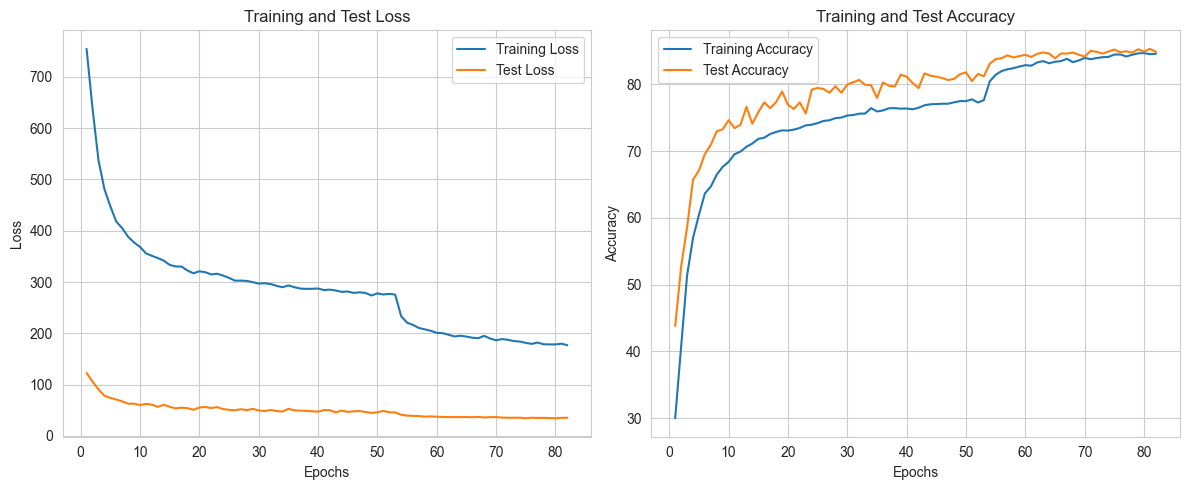

In [8]:
def training():
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(custom_model, device, train_data_loader, criterion, optimizer, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Update learning rate if needed
        scheduler.step(train_loss)

        test_loss, test_acc = test(custom_model, device, test_data_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(custom_model.state_dict())
            
        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}")

    custom_model.load_state_dict(best_model_wts)
    torch.save(custom_model.state_dict(), "best_custom_model.pt")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epoch + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

training()

It can be seen from the graphs that these hyperparameters are excellent for the model

### Transfer Learning Model
I chose to use *[resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)* pretrained model

In [28]:
# Loading the model
pretrained_model = models.resnet50(pretrained=True)
pretrained_model

C:\Users\roman\anaconda3\envs\gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\roman\anaconda3\envs\gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
#Modify conv1 to suit CIFAR-10
pretrained_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# Modify the final fully connected layer according to the number of classes
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)
model = pretrained_model.to(device)
print(model)
print(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Defining hyperparameters and train pretrained model

In [30]:
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, verbose=True, min_lr=0.0001)

C:\Users\roman\anaconda3\envs\gpu_env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [31]:
def training():
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(pretrained_model, device, train_data_loader, criterion, optimizer, epoch)
        # Update learning rate if needed
        scheduler.step(train_loss)
        test_loss, test_acc = test(pretrained_model, device, test_data_loader, criterion)
        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}")

    torch.save(pretrained_model.state_dict(), "pretrained_model.pt")

training()

100%|██████████| 390/390 [00:46<00:00,  8.45it/s, Loss=1.229225]


Train Epoch: 1, elapsed time:46.17s
Training accuracy 56.442, test accuracy 73.47
Training loss 479.39755618572235, test loss 59.969372153282166


100%|██████████| 390/390 [00:45<00:00,  8.54it/s, Loss=0.715726]


Train Epoch: 2, elapsed time:45.69s
Training accuracy 75.25, test accuracy 77.98
Training loss 279.1330566704273, test loss 50.49508208036423


100%|██████████| 390/390 [00:44<00:00,  8.83it/s, Loss=0.564335]


Train Epoch: 3, elapsed time:44.19s
Training accuracy 80.23, test accuracy 81.75
Training loss 220.09064388275146, test loss 42.125975638628006


100%|██████████| 390/390 [00:45<00:00,  8.61it/s, Loss=0.476314]


Train Epoch: 4, elapsed time:45.30s
Training accuracy 83.194, test accuracy 86.22
Training loss 185.7622802555561, test loss 31.396505802869797


100%|██████████| 390/390 [00:42<00:00,  9.28it/s, Loss=0.423431]


Train Epoch: 5, elapsed time:42.05s
Training accuracy 85.016, test accuracy 87.46
Training loss 165.137995287776, test loss 29.41676414012909


100%|██████████| 390/390 [00:43<00:00,  8.88it/s, Loss=0.384328]


Train Epoch: 6, elapsed time:43.94s
Training accuracy 86.312, test accuracy 87.71
Training loss 149.887880936265, test loss 29.20339871942997


100%|██████████| 390/390 [00:44<00:00,  8.81it/s, Loss=0.347152]


Train Epoch: 7, elapsed time:44.26s
Training accuracy 87.704, test accuracy 88.09
Training loss 135.38932456076145, test loss 27.647958926856518


100%|██████████| 390/390 [00:44<00:00,  8.78it/s, Loss=0.323485]

Train Epoch: 8, elapsed time:44.40s


Training accuracy 88.446, test accuracy 88.68
Training loss 126.15908908843994, test loss 26.207985058426857


100%|██████████| 390/390 [00:43<00:00,  9.06it/s, Loss=0.295214]


Train Epoch: 9, elapsed time:43.04s
Training accuracy 89.482, test accuracy 88.6
Training loss 115.13360287249088, test loss 27.82532472908497


100%|██████████| 390/390 [00:44<00:00,  8.79it/s, Loss=0.277545]


Train Epoch: 10, elapsed time:44.35s
Training accuracy 89.984, test accuracy 89.36
Training loss 108.24264468997717, test loss 25.8801991045475


100%|██████████| 390/390 [00:46<00:00,  8.47it/s, Loss=0.256444]


Train Epoch: 11, elapsed time:46.04s
Training accuracy 90.802, test accuracy 89.73
Training loss 100.01332538574934, test loss 24.712469577789307


100%|██████████| 390/390 [00:43<00:00,  9.02it/s, Loss=0.237412]


Train Epoch: 12, elapsed time:43.26s
Training accuracy 91.434, test accuracy 88.87
Training loss 92.59053409844637, test loss 26.34539870917797


100%|██████████| 390/390 [00:43<00:00,  8.96it/s, Loss=0.223933]


Train Epoch: 13, elapsed time:43.51s
Training accuracy 91.964, test accuracy 90.75
Training loss 87.33387926220894, test loss 22.203635573387146


100%|██████████| 390/390 [00:42<00:00,  9.10it/s, Loss=0.208850]


Train Epoch: 14, elapsed time:42.88s
Training accuracy 92.388, test accuracy 90.05
Training loss 81.45151249319315, test loss 24.25476135313511


100%|██████████| 390/390 [00:42<00:00,  9.21it/s, Loss=0.199536]


Train Epoch: 15, elapsed time:42.35s
Training accuracy 92.788, test accuracy 89.91
Training loss 77.8189089000225, test loss 24.527527436614037


100%|██████████| 390/390 [00:42<00:00,  9.26it/s, Loss=0.188597]


Train Epoch: 16, elapsed time:42.10s
Training accuracy 93.168, test accuracy 89.86
Training loss 73.55277848243713, test loss 26.47429023683071


100%|██████████| 390/390 [00:43<00:00,  9.02it/s, Loss=0.173914]


Train Epoch: 17, elapsed time:43.22s
Training accuracy 93.692, test accuracy 90.07
Training loss 67.82642460986972, test loss 24.21567030251026


100%|██████████| 390/390 [00:43<00:00,  8.98it/s, Loss=0.168548]


Train Epoch: 18, elapsed time:43.43s
Training accuracy 93.918, test accuracy 91.12
Training loss 65.73370351269841, test loss 22.587269887328148


100%|██████████| 390/390 [00:44<00:00,  8.85it/s, Loss=0.157886]


Train Epoch: 19, elapsed time:44.08s
Training accuracy 94.19, test accuracy 90.66
Training loss 61.57542236149311, test loss 23.845465306192636


100%|██████████| 390/390 [00:44<00:00,  8.84it/s, Loss=0.145643]


Train Epoch: 20, elapsed time:44.11s
Training accuracy 94.8, test accuracy 90.95
Training loss 56.80082455277443, test loss 24.358516313135624


# Evaluation

In [32]:
# Our Custom Model
model1 = custom_model
# Pretrained model
model2 = pretrained_model
model1.to(device)
model2.to(device)

# Load test dataset
test_images = np.load('task_2_test_images.npy')
test_labels = np.load('task_2_test_labels.npy')

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# create test_loader
test_dataset = CustomDataset(test_images, test_labels, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [33]:
def calculate_metrics(model, device, test_loader):
    """
    This function calculates roc_auc_score of the model and its inference speed and accuracy
    :param model: given model
    :param device: given device
    :param test_loader: loader with data
    :return: roc_auc_score, inference time, accuracy_score
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_time = 0
    num_samples = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            start_time = time()
            output = model(data)
            end_time = time()
            total_time += end_time - start_time
            num_samples += len(data)
            # Calculate predicted probabilities
            pred = output.cpu()
            preds = torch.nn.functional.softmax(output, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    inference_speed = num_samples / total_time  # Images per second
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    roc_auc = roc_auc_score(all_targets, all_preds, multi_class='ovr')
    return roc_auc, inference_speed


def calculate_model_size(model):
    """
    Source: https://stackoverflow.com/questions/71851474/how-to-find-the-size-of-a-deep-learning-model
    :param model: model
    :return: size of the model in MB
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024 ** 2
    return size_all_mb

### Calulate Metrics:
- **AUC-ROC**
- **Model Size**
- **Inference Speed**

In [34]:
# Measure AUC-ROC and Inference Speed
auc_roc_model1, inference_time_model1 = calculate_metrics(model1, device, test_loader)
auc_roc_model2, inference_time_model2 = calculate_metrics(model2, device, test_loader)
_, acc1 = test(model1, device, test_loader, criterion)
_, acc2 = test(model2, device, test_loader, criterion)

# Measure Model Size
model1_size_mb = calculate_model_size(model1)
model2_size_mb = calculate_model_size(model2)

# Display results
print(f"Custom model Accuracy {acc1:.3f}%")
print(f"Modified resnet50 model Accuracy {acc2:.3f}%")
print(f"Custom model AUC-ROC {auc_roc_model1:.3f}")
print(f"Modified resnet50 model AUC-ROC {auc_roc_model2:.3f}")
print(f"Custom model Size {model1_size_mb:.3f} MB")
print(f"Modified resnet50 model Size { model2_size_mb:.3f} MB")
print(f"Custom model Inference Time: {inference_time_model1:.3f} images/second")
print(f"Modified resnet50 model Inference Time: {inference_time_model2:.3f} images/second")

Custom model Accuracy 73.714%
Modified resnet50 model Accuracy 80.916%
Custom model AUC-ROC 0.961
Modified resnet50 model AUC-ROC 0.979
Custom model Size 7.514 MB
Modified resnet50 model Size 89.928 MB
Custom model Inference Time: 71131.797 images/second
Modified resnet50 model Inference Time: 12527.143 images/second


## Сonclusions from metrics
- **Accuracy score**: The modified model has accuracy almost 81% that is more than 7% bigger than custom model. Therefore, modified model defines images more precisely

- **Performance (AUC-ROC)**: The modified ResNet50 model achieves a higher AUC-ROC score of 0.979 compared to the custom model's AUC-ROC score of 0.961. This indicates that the modified ResNet50 model performs better in terms of classification accuracy on the cifar10 dataset.

- **Size**: The size of the modified ResNet50 model is significantly larger than that of the custom model. The modified ResNet50 model occupies 89.928 MB of storage space, whereas the custom model is much smaller, occupying only 7.514 MB. This suggests that the modified ResNet50 model is more complex and requires more parameters, leading to a larger memory footprint.

- **Inference Speed**: The custom model achieves a faster inference speed of 71131.797 images/second compared to the modified ResNet50 model's inference speed of 12527.143 images/second. This implies that the custom model is more efficient in terms of inference time, due to its simpler architecture and smaller size.

### Insights:
- The modified ResNet50 model outperforms the custom model in terms of classification accuracy, and AUC-ROC score. This indicates that the modified ResNet50 model might be better suited for tasks where high accuracy is paramount.
- However, the trade-off for this improved performance is a larger model size, which can be a concern in resource-constrained environments, especially in deployment scenarios where memory or storage space is limited.
- On the other hand, the custom model offers faster inference speed, making it more suitable for applications where real-time processing or low latency is critical.
- Ultimately, the choice between the two models depends on the specific requirements of the application, considering factors such as performance, size, and inference speed, as well as resource constraints and deployment environment.

### Saving custom model for bonus task

In [35]:
torch.save(model1, 'RomanMakeev.pth')